In [1]:
import netket as nk
from netket.operator.spin import sigmax, sigmaz, sigmay
from src.wilson import * 

## Parameters

In [2]:
L = 4

In [3]:
g = nk.graph.Square(L, pbc=True)
print(f'g.n_edges = {g.n_edges}, LxLx2 = {L**2 * 2}')
hi = nk.hilbert.Spin(s=1/2, N=g.n_edges) # note hilbert space is on edges
# there is no natural ordering to the hilbert space so we will have to impose one.
# this is specified by wilson.ordered_edges.
# as long as we respect this ordering across all implementations, things should work

g.n_edges = 32, LxLx2 = 32


$$
H = -K \sum_{\square} \prod_{ij \in \square} \sigma_{ij}^z - g \prod_{ij} \sigma_{ij}^x
$$

<Axes: >

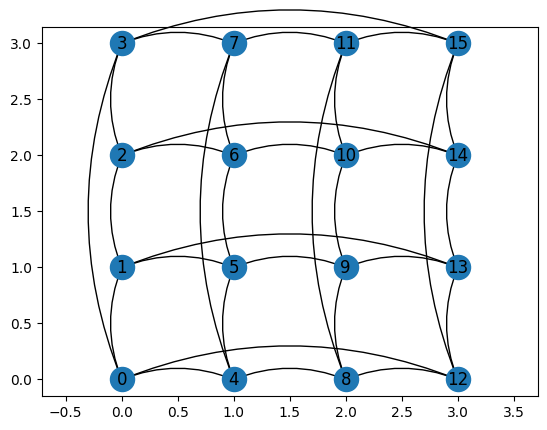

In [4]:
g.edges()
g.draw()

In [7]:
ord_edges = ordered_edges(g)
print(ord_edges)
i = 1
ord_edges[i + L**2], ord_edges[i]
# missing_edges = []
# for e in g.edges():
# 	if not (e in ord_edges or (e[1], e[0]) in ord_edges):
# 		missing_edges.append(e)
# missing_edges
# print(ord_edges)
# (i + 1) % (L-1)

left = ord_edges[i] 
right = ord_edges[i + 1]
upper = ord_edges[i + L**2]
lower = ord_edges[(i + L**2 + L) % (L**2)] # <--- this goes out of range
left, right, upper, lower

[(0, 4), (1, 5), (2, 6), (3, 7), (4, 8), (5, 9), (6, 10), (7, 11), (8, 12), (9, 13), (10, 14), (11, 15), (12, 0), (13, 1), (14, 2), (15, 3), (0, 1), (1, 2), (2, 3), (3, 0), (4, 5), (5, 6), (6, 7), (7, 4), (8, 9), (9, 10), (10, 11), (11, 8), (12, 13), (13, 14), (14, 15), (15, 12)]


((1, 5), (2, 6), (1, 2), (5, 9))

Equivariant layer: Two channels (I think for 2 valued dof), stride 1 CNN with leaky relu then wilson path pointwise multiplication, and skip connection.
Invariant layer: two channels, stride 1,. 
Network with equivariant layer tends to do better.

In [ ]:
def get_wilson_loops_and_paths(edges, L):
    """
    Given a list of edges, returns the wilson loops and paths for every vertex in the original lattice.
    Assumes a square lattice of size (L x L) with periodic boundary conditions, the input should be the output of ordered_edges(nk.graph.Square(L, pbc=True))
    Inputs:
    - edges: an ordered list of edges, where each edge is a tuple of the form (x,y) representing the connection between two nodes
    - L: the dimension of the lattice 
    Outputs:
    -wilson_loops: the wilson loops for each point in the graph, which is left_edge * right_edge * upper_edge * lower_edge
    -wilson_paths_left: the wilson paths for each point in the graph, when starting by going left, which is left_edge * lower_edge * right_edge
    -wilson_paths_up: the wilson paths for each point in the graph, when starting by going up, which is upper_edge * right_edge * lower_edge
    """
    wilson_loops = []
    wilson_paths_left = []
    wilson_paths_up = []
    for i in range(L**2):
        left = ord_edges[i] 
        right = ord_edges[i + 1]
        upper = ord_edges[i + L**2]
        lower = ord_edges[(i + L**2 + L) % (L**2)] # <--- this goes out of range

        S_left = get_score(left)
        S_right = get_score(right)
        S_upper = get_score(upper)
        S_lower = get_score(lower)

        wilson_loops.append(S_left * S_right * S_lower * S_upper)
        wilson_paths_left.append(S_left * S_lower * S_right)
        wilson_paths_up.append(S_upper * S_right * S_lower)

    return wilson_loops, wilson_paths_left, wilson_paths_up

        

    